In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee

In [3]:
import numpy as np
import pickle

cosmos_f = open('cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

# box = 'Box0_1400'
box = 'Box_n50_0_1400'
h = cosmo_params[box]['H0']/100

Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f) #Pkz is a dictonary of functions
Pk_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [4]:
#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

In [5]:
a_to_z

{0.25: 3.0,
 0.302679: 2.3038301302700224,
 0.366459: 1.7288182306888356,
 0.403224: 1.4800111104497748,
 0.488191: 1.0483786059144884,
 0.512095: 0.9527626709887815,
 0.537169: 0.8616115226306804,
 0.563471: 0.7747142266416549,
 0.591061: 0.691872750866662,
 0.620002: 0.6128980229096033,
 0.65036: 0.5376099391106464,
 0.715608: 0.3974131088528914,
 0.787402: 0.26999931420037027,
 0.866399: 0.15420262488760939,
 0.953321: 0.04896461947234987,
 1.0: 0.0}

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, 20 / R)
/home/users/delon/aemulusnu_massfunction/utils.py:100: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and c

1 1
(14,) (14,)


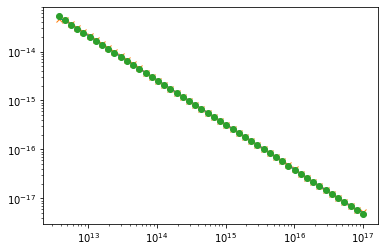

In [6]:
LOOKING_AT = [0.25]
from utils import *

N_data = {}
M_data = {}
from scipy.interpolate import interp1d

dlnσinvdMs = {}

vol = -1
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
    if(a not in LOOKING_AT):
        continue
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = N
    M_data[a] = Ms
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 50) #h^-1 Msolar
    
    
    R = [M_to_R(m, box, a) for m in M_numerics] #h^-1 Mpc
    
    
    sigma2s = [sigma2(Pk, r) for r in R]
    sigma = np.sqrt(sigma2s)
    lnsigmainv = -np.log(sigma)
    dlnsinvdM = np.gradient(lnsigmainv, M_numerics)

    dσ2dR = [dsigma2dR(Pk, r) for r in R]
    dRdMs = [dRdM(m_c, box, a) for m_c in M_numerics]
    dlnσinvdM_2 = -1/2 *np.array([a/b*c for (a,b,c) in zip(dσ2dR, sigma2s, dRdMs)])
    
    f_dlnsinvdM_log = interp1d(np.log10(M_numerics), dlnsinvdM,kind='cubic')
    f_dlnsinvdM = lambda x: f_dlnsinvdM_log(np.log10(x))

    dlnσinvdMs[a] = f_dlnsinvdM
    
    f_M = np.logspace(np.log10(np.min(Ms)), np.log10(np.max(Ms)-1),100)
    plt.plot(M_numerics, f_dlnsinvdM(M_numerics))
    plt.plot(M_numerics, dlnsinvdM, 'x')
    plt.plot(M_numerics, dlnσinvdM_2, 'o')

    plt.xscale('log')
    plt.yscale('log')
print(len(N_data), len(M_data))
for a in N_data:
    N_data[a] = np.array(N_data[a])
    M_data[a] = np.array(M_data[a])
    print(N_data[a].shape, M_data[a].shape)

In [7]:
from scipy.special import gamma
from scipy.optimize import curve_fit
from utils import *

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup

def tinker(a, M, 
           d,e,f,g,
           log10=False):    
    R = M_to_R(M, box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pkz[a_to_z[a]], R))  #
    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhom_a(box, a)/M
    oup *= dlnσinvdMs[a](M)
    if(log10):
        oup *= M*np.log(10)
    return oup/h**4 #h4 to fix units

In [8]:
from utils import *

In [9]:
a_list = list(NvMs.keys())
print(a_list)

[0.25, 0.302679, 0.366459, 0.403224, 0.488191, 0.512095, 0.537169, 0.563471, 0.591061, 0.620002, 0.65036, 0.715608, 0.787402, 0.866399, 0.953321, 1.0]


In [10]:
from scipy.stats import poisson
param_names = ['d',
               'e',
               'f', 
               'g',]
FIXED_VALS = {}

In [11]:
def log_prior(param_values):
    #uniform prior
    for param in param_values:
        if(param< 0 or param>5):
            return -np.inf
    return 0

In [12]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

In [13]:
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [14]:
def calculate_inner_product(X, K_X):
    """
    Calculates -1/2 X^T (K_X)^(-1) X.
    
    Args:
        X (np.ndarray): Input array of shape (n,).
        K_X (np.ndarray): Input array of shape (n, n).
        
    Returns:
        float: Resulting scalar value.
    """
    # Ensure X and K_X have compatible shapes
    assert X.shape[0] == K_X.shape[0], "Number of rows in X must be equal to the number of rows in K_X"
    assert K_X.shape[0] == K_X.shape[1], "K_X must be a square matrix"
    
    # Calculate (K_X)^(-1)
    K_X_inv = np.linalg.inv(K_X)
    
    # Calculate X^T (K_X)^(-1) X
    inner_product = -0.5 * np.dot(np.dot(X.T, K_X_inv), X)
    
    return inner_product

def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(log_prior(param_values) == -np.inf):
        return -np.inf
    
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [tinker(a, M_c,**params,)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
#         if(a_to_z[a] >=2):
# #             print(1)
#             continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
        
    log_probs = [calculate_inner_product(model_vals[a]-N_data[a], jackknife[a][1]) for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

In [15]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -1e22
    return lp + log_prob(param_values)

In [16]:
from utils import *
guess = np.random.uniform(size=(len(param_names)))
while(not np.isfinite(log_likelihood(guess))):
    guess = np.random.uniform(size=(len(param_names)))

#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess)

In [17]:
print(result)
print(result['x'])
MLE_params = dict(zip(param_names, result['x']))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 29798.69835162965
        x: [ 4.880e-01  2.179e-01  5.441e-01  4.509e-01]
      nit: 4
      jac: [ 6.089e+01 -2.345e+01  1.030e+03  6.654e+03]
 hess_inv: [[ 7.004e-03  4.103e-02 -5.400e-03 -4.561e-05]
            [ 4.103e-02  2.404e-01 -3.164e-02 -2.678e-04]
            [-5.400e-03 -3.164e-02  4.165e-03  3.531e-05]
            [-4.561e-05 -2.678e-04  3.531e-05  3.301e-07]]
     nfev: 284
     njev: 52
[0.48802938 0.2179376  0.54406649 0.45088255]


/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, 20 / R)


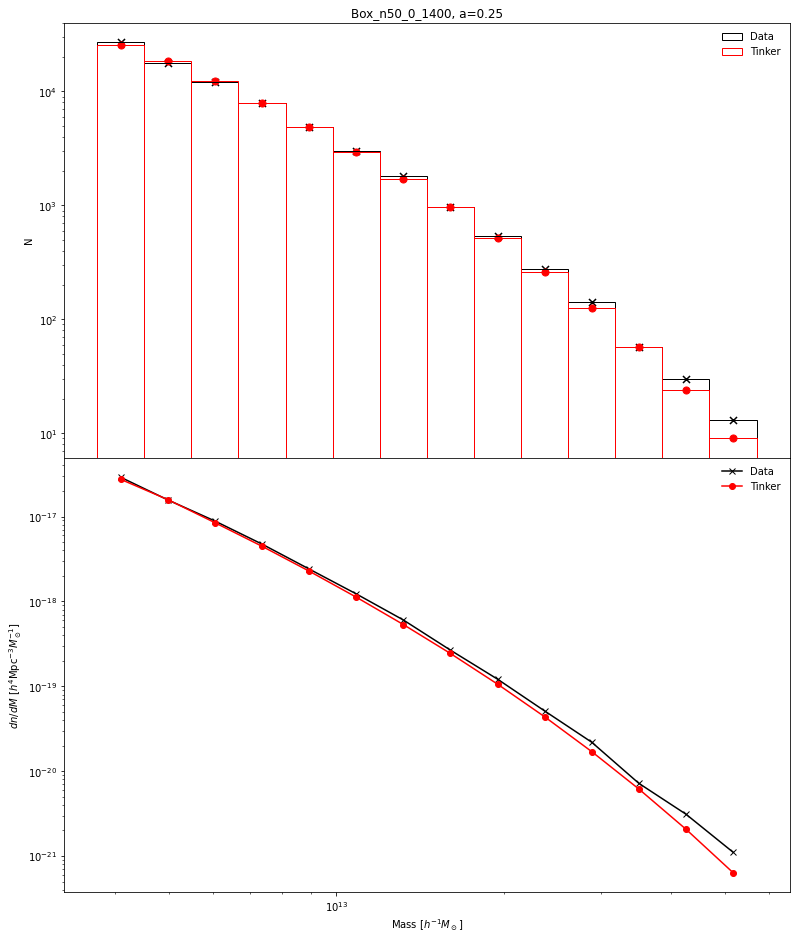

In [18]:
from scipy.interpolate import interp1d
i=0
for a in N_data:
    z = a_to_z[a]
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,16))
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]



    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (N/vol)/dM

    tinker_eval = [tinker(a, M_c,**MLE_params) for M_c in Ms]

    axs[1].plot(Ms, dndM, 'x-', color='black', label='Data')
    axs[1].plot(Ms, tinker_eval, 'o-', color='red', label='Tinker')



    tinker_eval = [tinker(a, M_c,**MLE_params,)*vol for M_c in M_numerics]
    
    f_dndM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    
    edge_centers = [np.sqrt(edge[0]*edge[1]) for edge in edge_pairs]
    
    axs[0].scatter(Ms, N, s=50, marker='x', c='black')
    axs[0].scatter(edge_centers, tinker_eval, s=50 , marker='o', c='red')
    
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges), align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1], height=tinker_eval, width=np.diff(edges), align='edge', fill=False, ec='red', label='Tinker')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend(frameon=False)
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$dn/dM\ [h^4{\rm Mpc}^{-3}M_\odot^{-1}]$')
    axs[0].set_title('%s, a=%.2f'%(box, a))
    i+=1
#     plt.savefig('figures/%s_MLFits_a%.2f.pdf'%(box, a), bbox_inches='tight')
    plt.show()


nwalkers = 32
ndim = len(param_names)

initialpos = np.array([result['x'] for _ in range(nwalkers)]) + 1e-4 * np.random.normal(size=(nwalkers, ndim))

print(initialpos)

from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood,
    pool=Pool()
)

sampler.run_mcmc(initialpos, 1000, progress=True);

fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
labels = param_names

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

import corner
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=labels)


params_final = dict(zip(param_names,np.percentile(samples,  50,axis=0)))

print(params_final)

from scipy.interpolate import interp1d
i=0
for a in N_data:
    z = a_to_z[a]
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,16))
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]



    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (N/vol)/dM

    tinker_eval = [tinker(a, M_c,**params_final,) for M_c in Ms]

    axs[1].plot(Ms, dndM, 'x-', color='black')
    axs[1].plot(Ms, tinker_eval, 'o-', color='red')



    tinker_eval = [tinker(a, M_c,**params_final,)*vol for M_c in M_numerics]
    
    f_dndM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    
    edge_centers = [np.sqrt(edge[0]*edge[1]) for edge in edge_pairs]
    
    axs[0].scatter(Ms, N, s=50, marker='x', c='black')
    axs[0].scatter(edge_centers, tinker_eval, s=50 , marker='o', c='red')
    
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges), align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1], height=tinker_eval, width=np.diff(edges), align='edge', fill=False, ec='red', label='Tinker')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend(frameon=False)
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$dn/dM\ [h^4{\rm Mpc}^{-3}M_\odot^{-1}]$')
    axs[0].set_title('%s, a=%.1f'%(box, a))
    i+=1
#     plt.savefig('figures/%s_ML+MCMCFits_a%.1f.pdf'%(box, a), bbox_inches='tight')
    plt.show()